-Training completo tra 5mln a 10mln di TimeStamp e tra 5000 e 10000 episodi

-Per un tuning rapido da 500k a 1mln di TimeStamp e tra 500 a 1k episodi per trial (consigliati 500 trial)

-Per i test preliminari 1mln di timestamp e 1k/2k episodi

- CHAT con search dice che per il train vanno bene anche 1mln di timestamp

In [155]:
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import numpy as np
import matplotlib.pyplot as plt
import os


from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import HParam
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

In [156]:
class HParamCallback(BaseCallback):
    """
    Saves the hyperparameters and metrics at the start of the training, and logs them to TensorBoard.
    """

    def _on_training_start(self) -> None:
        hparam_dict = {
            "algorithm": self.model.__class__.__name__,
            "learning rate": self.model.learning_rate,
            "gamma": self.model.gamma,
        }
        # define the metrics that will appear in the `HPARAMS` Tensorboard tab by referencing their tag
        # Tensorbaord will find & display metrics from the `SCALARS` tab
        metric_dict = {
            #"rollout/ep_len_mean": 0,
            #"train/value_loss": 0.0,
        }
        self.logger.record(
            "hparams",
            HParam(hparam_dict, metric_dict),
            exclude=("stdout", "log", "json", "csv"),
        )

    def _on_step(self) -> bool:
        return True

BEST_1 (PPO_4) -> {'reset_noise_scale': 0.16872520546404454, 'forward_reward_weight': 0.569165596187308, 'ctrl_cost_weight': 0.15369909636721105, 'healthy_reward': 1.1651483169773327, 'learning_rate': 0.00025118614395972893, 'n_steps': 4096, 'batch_size': 256, 'gamma': 0.9900195327210904, 'gae_lambda': 0.8063306496367846, 'clip_range': 0.1411162146550987, 'ent_coef': 0.006226601057899701, 'variance_penalty_weight': 0.0007310600475679448}


In [157]:
# Ipreparametri dell'envrionment
hp_reset_noise_scale=0.10405074414945424 # scala del rumore quando l'ambiente viene resettato 
hp_forward_reward_weight=0.5940601384640877 # peso del reward per il movimento in avanti
hp_ctrl_cost_weight=0.14771040407991193 # peso del reward per il controllo
hp_healthy_reward =1.4039427670916238 # reward per la salute


# Iperparametri del modello/policy
hp_policy="MlpPolicy"           # Tipo di policy: una rete neurale MLP (Multilayer Perceptron) che mappa osservazioni ad azioni
hp_learning_rate=0.00014010166026390974           # Tasso di apprendimento: controlla la velocità con cui il modello apprende aggiornando i pesi
hp_n_steps=4096                 # Numero di passi da eseguire nell'ambiente per ogni ciclo di aggiornamento della policy
hp_batch_size=64                # Dimensione del batch per gli aggiornamenti stocastici: suddivide i dati raccolti nei mini-batch
hp_n_epochs=10                  # Numero di volte (epoch) che il dataset raccolto viene utilizzato per aggiornare la policy
hp_gamma=0.9974446213345484      # Fattore di sconto: determina l'importanza delle ricompense future rispetto a quelle immediate
hp_gae_lambda=0.8025419607496327              # Parametro per il Generalized Advantage Estimation (GAE): bilancia bias e varianza nella stima dell'advantage
hp_clip_range=0.16218657788555388               # Intervallo di clipping: limita le variazioni della policy per mantenere aggiornamenti stabili
hp_ent_coef=0.00017603718662988996                 # Coefficiente di entropia: controlla l'incentivo all'esplorazione; 0 significa nessun bonus per l'entropia


In [158]:
def make_env():
    """
    Crea e restituisce l'ambiente Ant-v5 dalla libreria Gymnasium.

    Questa funzione istanzia l'ambiente "Ant-v5", uno degli ambienti recenti e ben supportati
    in Gymnasium. I parametri usati sono:
    - reset_noise_scale (0.1): determina la scala del rumore quando l'ambiente viene resettato.
    - render_mode ('None'): indica che non verrà effettuato il rendering durante l'esecuzione.

    Ritorna:
        gym.Env: l'ambiente Ant-v5 inizializzato.
    """
    
    # Ant-v5 è l’ambiente più recente in Gymnasium.
    return gym.make("Ant-v5", 
                    reset_noise_scale=hp_reset_noise_scale, # scala del rumore quando l'ambiente viene resettato 
                    forward_reward_weight=hp_forward_reward_weight, # peso del reward per il movimento in avanti
                    ctrl_cost_weight=hp_ctrl_cost_weight, # peso del reward per il controllo
                    healthy_reward =hp_healthy_reward, # reward per la salute
                    render_mode='none')

In [159]:
# 1. Creiamo un ambiente vettorializzato (Vectorized Environment)
# Utilizziamo DummyVecEnv per gestire più istanze dell'ambiente come se fossero una singola entità.
# Qui passiamo la funzione make_env (definita in un'altra cella) che crea l'ambiente "Ant-v5".
env = DummyVecEnv([make_env])  

# 2. Normalizziamo osservazioni (obs) e ricompense (reward)
# VecNormalize scala le osservazioni e le ricompense per stabilizzare l'allenamento.
# Parametri:
#   norm_obs=True   -> Abilita la normalizzazione delle osservazioni.
#   norm_reward=True -> Abilita la normalizzazione delle ricompense.
#   clip_obs=10.     -> Limita i valori normalizzati dell'osservazione a un range [-10, 10] per evitare estremi.
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

/Users/ignazioemanuelepicciche/Documents/Ignazio PC/ucbm/deep_learning/Reinforcement_Learning_MuJoCu/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:734: UserWarning: WARN: The environment is being initialised with render_mode='none' that is not in the possible render_modes (['human', 'rgb_array', 'depth_array']).
  logger.warn(


In [160]:
# 3. Definiamo il modello RL (PPO) con spiegazioni dettagliate per ciascun parametro

model = PPO(
    policy=hp_policy,           # Tipo di policy: una rete neurale MLP (Multilayer Perceptron) che mappa osservazioni ad azioni
    env=env,                      # Ambiente di addestramento: usa l'ambiente vettorializzato e normalizzato creato in precedenza
    learning_rate=hp_learning_rate,           # Tasso di apprendimento: controlla la velocità con cui il modello apprende aggiornando i pesi
    n_steps=hp_n_steps,                 # Numero di passi da eseguire nell'ambiente per ogni ciclo di aggiornamento della policy
    batch_size=hp_batch_size,                # Dimensione del batch per gli aggiornamenti stocastici: suddivide i dati raccolti nei mini-batch
    n_epochs=hp_n_epochs,                  # Numero di volte (epoch) che il dataset raccolto viene utilizzato per aggiornare la policy
    gamma=hp_gamma,      # Fattore di sconto: determina l'importanza delle ricompense future rispetto a quelle immediate
    gae_lambda=hp_gae_lambda,              # Parametro per il Generalized Advantage Estimation (GAE): bilancia bias e varianza nella stima dell'advantage
    clip_range=hp_clip_range,               # Intervallo di clipping: limita le variazioni della policy per mantenere aggiornamenti stabili
    ent_coef=hp_ent_coef,                 # Coefficiente di entropia: controlla l'incentivo all'esplorazione; 0 significa nessun bonus per l'entropia
    verbose=1,                    # Livello di verbosità: 1 per stampare informazioni di log utili durante l'addestramento
    tensorboard_log="./ppo_Ant_tensorboard/",  # Cartella per salvare i log di TensorBoard
    device='mps'                    # Specifica l'uso della GPU su Apple Silicon
)

Using mps device


/Users/ignazioemanuelepicciche/Documents/Ignazio PC/ucbm/deep_learning/Reinforcement_Learning_MuJoCu/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [161]:
eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, clip_obs=10.)

In [162]:
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/best_model",
    log_path="./logs/",
    eval_freq=10000,
    deterministic=True,
    render=False
)

In [163]:
# 4. Alleniamo il modello
# Il parametro total_timesteps indica il numero totale di iterazioni (o passi)
# che il modello eseguirà durante l'allenamento. Ogni timestep rappresenta un'interazione
# con l'ambiente in cui il modello esegue un'azione e riceve un feedback, che viene poi
# usato per aggiornare la sua politica interna.
total_timesteps = 1000000  # Puoi aumentare questo valore per permettere al modello di acquisire più esperienza.
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3030120753.py, line 7)

In [96]:
#5. Salviamo il modello
model.save("ppo_Ant_model")
env.save("vecnormalize_Ant.pkl")  # salviamo anche i parametri di normalizzazione

In [99]:
# 200-400 episodi sono adeguati 
def evaluate_policy(env, policy, episodes=500):
    """
    Valuta una policy addestrata su un ambiente dato.

    Parametri:
    - env: L'ambiente di simulazione.
    - policy: La policy addestrata da valutare.
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()  # Reset dell'ambiente per iniziare un nuovo episodio
        done = False
        total_reward = 0
        while not done:
            action, _ = policy.predict(obs)  # Predice l'azione da eseguire
            obs, reward, done, _ = env.step(action)  # Esegue l'azione e ottiene il feedback dall'ambiente
            total_reward += reward  # Accumula la ricompensa ottenuta
        total_rewards.append(total_reward)  # Aggiunge la ricompensa totale dell'episodio alla lista
    return np.mean(total_rewards), np.std(total_rewards)  # Calcola e ritorna la media e la deviazione standard delle ricompense

# 200-400 episodi sono adeguati 
def evaluate_random_policy(env, episodes=500):
    """
    Valuta una policy casuale su un ambiente dato.

    Parametri:
    - env: L'ambiente di simulazione.
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()  # Reset dell'ambiente per iniziare un nuovo episodio
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()  # Genera un'azione casuale
            obs, reward, done, _ = env.step(np.array([action]))  # Esegue l'azione e ottiene il feedback dall'ambiente
            total_reward += reward  # Accumula la ricompensa ottenuta
        total_rewards.append(total_reward)  # Aggiunge la ricompensa totale dell'episodio alla lista
    return np.mean(total_rewards), np.std(total_rewards)  # Calcola e ritorna la media e la deviazione standard delle ricompense

Trained Policy: Mean Reward: 2.74877667427063, Std: 6.1324005126953125
Random Policy: Mean Reward: 5.563947677612305, Std: 9.290725708007812


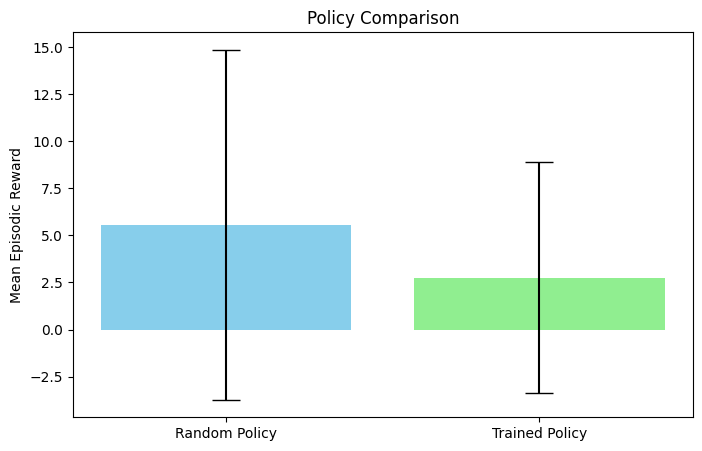

In [100]:
# Valutazione dopo l'addestramento
mean_reward_trained, std_reward_trained = evaluate_policy(env, model)  # Valuta la policy addestrata
mean_reward_random, std_reward_random = evaluate_random_policy(env)  # Valuta la policy casuale

# Stampa dei risultati
print(f"Trained Policy: Mean Reward: {mean_reward_trained}, Std: {std_reward_trained}")
print(f"Random Policy: Mean Reward: {mean_reward_random}, Std: {std_reward_random}")

# Creazione del grafico di confronto
labels = ['Random Policy', 'Trained Policy']
means = [mean_reward_random, mean_reward_trained]
stds = [std_reward_random, std_reward_trained]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Episodic Reward')
plt.title('Policy Comparison')
plt.show()